In [56]:
# %% [markdown]
# ## 1. Chargement des Bibliothèques
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
import keras.backend as K
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [57]:
# %% [markdown]
# ## 2. Paramètres et Configuration
IMG_SIZE = (256, 256)  # Ajuster selon vos données
BATCH_SIZE = 8
EPOCHS = 100
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
DATA_PATH = '/home/kevin/datasets/livrable2/processed'

In [58]:
# %% [markdown]
# ## 3. Chargement et Préparation des Données (Version Corrigée)

def load_data(data_path):
    # Vérification hiérarchique renforcée
    noisy_path = os.path.join(data_path, 'noisy')
    clean_path = os.path.join(data_path, 'clean')
    
    for path in [noisy_path, clean_path]:
        if not os.path.isdir(path):
            raise ValueError(f"Dossier introuvable: {path}")
    
    # Collecte avec vérification d'extension
    valid_ext = ['.jpg', '.jpeg', '.png']
    
    noisy_files = sorted([f for f in os.listdir(noisy_path) 
                         if os.path.splitext(f)[1].lower() in valid_ext])
    clean_files = sorted([f for f in os.listdir(clean_path)
                         if os.path.splitext(f)[1].lower() in valid_ext])

    # Lecture avec progression et gestion d'erreur
    noisy_imgs, clean_imgs = [], []
    for idx, (nfile, cfile) in enumerate(zip(noisy_files, clean_files)):
        noisy_img = cv2.imread(os.path.join(noisy_path, nfile))
        clean_img = cv2.imread(os.path.join(clean_path, cfile))
        
        if noisy_img is None:
            print(f"ERREUR: Échec de lecture de {nfile} (taille attendue: {IMG_SIZE})")
            continue
        if clean_img is None:
            print(f"ERREUR: Échec de lecture de {cfile} (taille attendue: {IMG_SIZE})")
            continue
        
        # Vérification de la taille
        if noisy_img.shape != (*IMG_SIZE, 3):
            print(f"Avertissement: {nfile} a une taille {noisy_img.shape}, ignoré")
            continue
            
        noisy_imgs.append(noisy_img)
        clean_imgs.append(clean_img)
        
        if (idx+1) % 10 == 0:
            print(f"Traité {idx+1}/{len(noisy_files)} paires")

    print(f"\nSuccès: {len(noisy_imgs)} paires valides sur {len(noisy_files)}")
    return np.array(noisy_imgs), np.array(clean_imgs)

# Chargement avec vérification
try:
    X_noisy, X_clean = load_data(DATA_PATH)
except Exception as e:
    print(f"Erreur: {e}")
    raise

# Vérification des dimensions
assert X_noisy.shape == X_clean.shape, "Dimensions incohérentes entre X_noisy et X_clean!"

# Normalisation [0,1]
X_noisy = X_noisy.astype('float32') / 255.0
X_clean = X_clean.astype('float32') / 255.0

# Split adaptatif pour petits datasets
TOTAL_SIZE = len(X_noisy)
print(f"Total d'images: {TOTAL_SIZE}")
if TOTAL_SIZE < 100:
    # Stratégie pour datasets réduits
    TEST_SPLIT = max(1, int(0.1 * TOTAL_SIZE))
    VAL_SPLIT = max(1, int(0.2 * TOTAL_SIZE))
else:
    TEST_SPLIT = 0.1
    VAL_SPLIT = 0.2

# Split avec shuffle stratifié
X_train, X_temp, y_train, y_temp = train_test_split(
    X_noisy, X_clean, 
    test_size=(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED,
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=TEST_SPLIT/(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED
)

print(f"\nSplit Final:")
print(f"- Train: {len(X_train)}")
print(f"- Val: {len(X_val)}")
print(f"- Test: {len(X_test)}")

Traité 10/298 paires
Traité 20/298 paires
Traité 30/298 paires
Traité 40/298 paires
Traité 50/298 paires
Traité 60/298 paires
Traité 70/298 paires
Traité 80/298 paires
Traité 90/298 paires
Traité 100/298 paires
Traité 110/298 paires
Traité 120/298 paires
Traité 130/298 paires
Traité 140/298 paires
Traité 150/298 paires
Traité 160/298 paires
Traité 170/298 paires
Traité 180/298 paires
Traité 190/298 paires
Traité 200/298 paires
Traité 210/298 paires
Traité 220/298 paires
Traité 230/298 paires
Traité 240/298 paires
Traité 250/298 paires
Traité 260/298 paires
Traité 270/298 paires
Traité 280/298 paires
Traité 290/298 paires

Succès: 298 paires valides sur 298
Total d'images: 298

Split Final:
- Train: 208
- Val: 60
- Test: 30


In [59]:
class SpatialAttention(layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.dense1 = layers.Dense(channels // self.ratio, activation='relu', 
                                  kernel_initializer='he_normal', use_bias=False)
        self.dense2 = layers.Dense(channels, activation='sigmoid', 
                                  kernel_initializer='he_normal', use_bias=False)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super(SpatialAttention, self).build(input_shape)

    def call(self, x):
        channels = x.shape[-1]
        
        # Channel attention branch
        avg_pool = layers.GlobalAveragePooling2D()(x)
        avg_pool = layers.Reshape((1, 1, channels))(avg_pool)
        avg_pool = self.dense1(avg_pool)
        avg_pool = self.dense2(avg_pool)
        
        # Spatial attention branch
        # Use tf.reduce_max instead of K.max
        max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
        # Use tf.reduce_mean instead of K.mean
        avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate()([max_pool, avg_pool_spatial])
        spatial = self.conv(concat)
        
        # Apply attention
        return x * avg_pool * spatial

def build_cae(input_shape=(256,256,3)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # Bottleneck with Spatial Attention
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = SpatialAttention()(x)  # Using our custom attention layer
    
    # Decoder
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same')(x)
    
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    
    outputs = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs, outputs)
    return model

In [60]:
# %% [markdown]
# ## 5. Métriques Personnalisées
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [61]:
# %% [markdown]
# ## 6. Compilation et Entraînement
model = build_cae()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mse',
              metrics=[PSNR, SSIM])

model.summary()

# Callbacks
early_stop = callbacks.EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention_4             │ (None, 64, 64, 256)    │        16,483 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 758,630 (2.89 MB)

 Trainable params: 758,246 (2.89 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
 3/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0754 - psnr: 11.3719 - ssim: 0.2774

2025-04-14 18:44:09.793769: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 200 bytes spill stores, 200 bytes spill loads



25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0440 - psnr: 14.4574 - ssim: 0.3492

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.0428 - psnr: 14.6051 - ssim: 0.3527 - val_loss: 0.0772 - val_psnr: 11.4526 - val_ssim: 0.3727 - learning_rate: 1.0000e-04
Epoch 2/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0142 - psnr: 18.8078 - ssim: 0.4679

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0142 - psnr: 18.8340 - ssim: 0.4685 - val_loss: 0.0732 - val_psnr: 11.6887 - val_ssim: 0.3798 - learning_rate: 1.0000e-04
Epoch 3/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0118 - psnr: 19.6413 - ssim: 0.5048

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0117 - psnr: 19.6572 - ssim: 0.5049 - val_loss: 0.0689 - val_psnr: 11.9504 - val_ssim: 0.3879 - learning_rate: 1.0000e-04
Epoch 4/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0108 - psnr: 19.9981 - ssim: 0.5227

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0108 - psnr: 20.0126 - ssim: 0.5228 - val_loss: 0.0641 - val_psnr: 12.2667 - val_ssim: 0.3982 - learning_rate: 1.0000e-04
Epoch 5/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0100 - psnr: 20.3005 - ssim: 0.5350

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0100 - psnr: 20.3099 - ssim: 0.5350 - val_loss: 0.0581 - val_psnr: 12.6968 - val_ssim: 0.4124 - learning_rate: 1.0000e-04
Epoch 6/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0095 - psnr: 20.5449 - ssim: 0.5441

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0095 - psnr: 20.5499 - ssim: 0.5441 - val_loss: 0.0507 - val_psnr: 13.2852 - val_ssim: 0.4315 - learning_rate: 1.0000e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0090 - psnr: 20.7517 - ssim: 0.5512

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0090 - psnr: 20.7530 - ssim: 0.5511 - val_loss: 0.0424 - val_psnr: 14.0726 - val_ssim: 0.4555 - learning_rate: 1.0000e-04
Epoch 8/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0087 - psnr: 20.9281 - ssim: 0.5571

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0087 - psnr: 20.9301 - ssim: 0.5570 - val_loss: 0.0338 - val_psnr: 15.0646 - val_ssim: 0.4822 - learning_rate: 1.0000e-04
Epoch 9/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0084 - psnr: 21.0832 - ssim: 0.5621

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0084 - psnr: 21.0853 - ssim: 0.5620 - val_loss: 0.0256 - val_psnr: 16.2818 - val_ssim: 0.5094 - learning_rate: 1.0000e-04
Epoch 10/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0081 - psnr: 21.2190 - ssim: 0.5665

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0081 - psnr: 21.2213 - ssim: 0.5664 - val_loss: 0.0187 - val_psnr: 17.6569 - val_ssim: 0.5335 - learning_rate: 1.0000e-04
Epoch 11/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0079 - psnr: 21.3409 - ssim: 0.5705

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0079 - psnr: 21.3433 - ssim: 0.5704 - val_loss: 0.0138 - val_psnr: 19.0110 - val_ssim: 0.5524 - learning_rate: 1.0000e-04
Epoch 12/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0077 - psnr: 21.4466 - ssim: 0.5741

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0077 - psnr: 21.4490 - ssim: 0.5739 - val_loss: 0.0110 - val_psnr: 19.9587 - val_ssim: 0.5654 - learning_rate: 1.0000e-04
Epoch 13/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0076 - psnr: 21.5449 - ssim: 0.5775

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0076 - psnr: 21.5470 - ssim: 0.5773 - val_loss: 0.0101 - val_psnr: 20.2267 - val_ssim: 0.5737 - learning_rate: 1.0000e-04
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0074 - psnr: 21.6340 - ssim: 0.5804 - val_loss: 0.0103 - val_psnr: 20.0508 - val_ssim: 0.5788 - learning_rate: 1.0000e-04
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0073 - psnr: 21.7175 - ssim: 0.5833 - val_loss: 0.0110 - val_psnr: 19.7397 - val_ssim: 0.5827 - learning_rate: 1.0000e-04
Epoch 16/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0071 - psnr: 21.7934 - ssim: 0.5860 - val_loss: 0.0116 - val_psnr: 19.5105 - val_ssim: 0.5865 - learning_rate: 1.0000e-04
Epoch 17/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0070 - psnr: 21.8662 - ssim: 0.5886 - val_loss: 0.0119 - val_psnr: 19.4225 - val_ssim: 0.5907 - learning_rate: 1.0000e-04
Epoch 18/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0069 - psnr: 21.9363 - ss

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0067 - psnr: 22.0968 - ssim: 0.5941 - val_loss: 0.0089 - val_psnr: 20.6707 - val_ssim: 0.6005 - learning_rate: 5.0000e-05
Epoch 20/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0066 - psnr: 22.1436 - ssim: 0.5946

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0066 - psnr: 22.1438 - ssim: 0.5943 - val_loss: 0.0080 - val_psnr: 21.1734 - val_ssim: 0.6028 - learning_rate: 5.0000e-05
Epoch 21/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0065 - psnr: 22.1965 - ssim: 0.5956

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0065 - psnr: 22.1962 - ssim: 0.5953 - val_loss: 0.0074 - val_psnr: 21.5156 - val_ssim: 0.6051 - learning_rate: 5.0000e-05
Epoch 22/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0064 - psnr: 22.2349 - ssim: 0.5964

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0064 - psnr: 22.2347 - ssim: 0.5961 - val_loss: 0.0070 - val_psnr: 21.8164 - val_ssim: 0.6068 - learning_rate: 5.0000e-05
Epoch 23/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0064 - psnr: 22.2732 - ssim: 0.5973

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0064 - psnr: 22.2727 - ssim: 0.5970 - val_loss: 0.0066 - val_psnr: 22.0975 - val_ssim: 0.6082 - learning_rate: 5.0000e-05
Epoch 24/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0063 - psnr: 22.3077 - ssim: 0.5981

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0063 - psnr: 22.3069 - ssim: 0.5979 - val_loss: 0.0062 - val_psnr: 22.3410 - val_ssim: 0.6093 - learning_rate: 5.0000e-05
Epoch 25/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0063 - psnr: 22.3408 - ssim: 0.5990

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0063 - psnr: 22.3397 - ssim: 0.5988 - val_loss: 0.0060 - val_psnr: 22.5475 - val_ssim: 0.6101 - learning_rate: 5.0000e-05
Epoch 26/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0062 - psnr: 22.3712 - ssim: 0.5998

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0062 - psnr: 22.3699 - ssim: 0.5996 - val_loss: 0.0058 - val_psnr: 22.7124 - val_ssim: 0.6108 - learning_rate: 5.0000e-05
Epoch 27/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0062 - psnr: 22.4014 - ssim: 0.6007

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0062 - psnr: 22.3999 - ssim: 0.6004 - val_loss: 0.0057 - val_psnr: 22.8319 - val_ssim: 0.6113 - learning_rate: 5.0000e-05
Epoch 28/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0062 - psnr: 22.4304 - ssim: 0.6015

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0062 - psnr: 22.4287 - ssim: 0.6013 - val_loss: 0.0056 - val_psnr: 22.9160 - val_ssim: 0.6117 - learning_rate: 5.0000e-05
Epoch 29/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0061 - psnr: 22.4586 - ssim: 0.6023

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0061 - psnr: 22.4566 - ssim: 0.6021 - val_loss: 0.0055 - val_psnr: 22.9698 - val_ssim: 0.6119 - learning_rate: 5.0000e-05
Epoch 30/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0061 - psnr: 22.4853 - ssim: 0.6031

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0061 - psnr: 22.4831 - ssim: 0.6029 - val_loss: 0.0055 - val_psnr: 23.0011 - val_ssim: 0.6121 - learning_rate: 5.0000e-05
Epoch 31/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0060 - psnr: 22.5115 - ssim: 0.6039

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0061 - psnr: 22.5092 - ssim: 0.6037 - val_loss: 0.0054 - val_psnr: 23.0178 - val_ssim: 0.6123 - learning_rate: 5.0000e-05
Epoch 32/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0060 - psnr: 22.5375 - ssim: 0.6047

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0060 - psnr: 22.5350 - ssim: 0.6044 - val_loss: 0.0054 - val_psnr: 23.0262 - val_ssim: 0.6125 - learning_rate: 5.0000e-05
Epoch 33/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0060 - psnr: 22.5613 - ssim: 0.6054

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0060 - psnr: 22.5586 - ssim: 0.6052 - val_loss: 0.0054 - val_psnr: 23.0300 - val_ssim: 0.6127 - learning_rate: 5.0000e-05
Epoch 34/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0059 - psnr: 22.5863 - ssim: 0.6062

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0060 - psnr: 22.5835 - ssim: 0.6059 - val_loss: 0.0054 - val_psnr: 23.0326 - val_ssim: 0.6129 - learning_rate: 5.0000e-05
Epoch 35/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0058 - psnr: 22.6812 - ssim: 0.6073

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0058 - psnr: 22.6762 - ssim: 0.6071 - val_loss: 0.0054 - val_psnr: 23.0424 - val_ssim: 0.6131 - learning_rate: 2.5000e-05
Epoch 36/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0059 - psnr: 22.6292 - ssim: 0.6065 - val_loss: 0.0054 - val_psnr: 23.0056 - val_ssim: 0.6145 - learning_rate: 2.5000e-05
Epoch 37/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0059 - psnr: 22.6437 - ssim: 0.6074 - val_loss: 0.0055 - val_psnr: 22.9950 - val_ssim: 0.6150 - learning_rate: 2.5000e-05
Epoch 38/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0059 - psnr: 22.6646 - ssim: 0.6080 - val_loss: 0.0054 - val_psnr: 23.0056 - val_ssim: 0.6153 - learning_rate: 2.5000e-05
Epoch 39/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0058 - psnr: 22.6854 - ssim: 0.6084 - val_loss: 0.0054 - val_psnr: 23.0227 - val_ssim: 0.6156 - learning_rate: 2.5000e-05
Epoch 40/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0057 - psnr: 22.7814 - ss

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0057 - psnr: 22.8226 - ssim: 0.6099 - val_loss: 0.0054 - val_psnr: 23.0568 - val_ssim: 0.6162 - learning_rate: 1.2500e-05
Epoch 42/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0057 - psnr: 22.8321 - ssim: 0.6100

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0057 - psnr: 22.8341 - ssim: 0.6098 - val_loss: 0.0054 - val_psnr: 23.0612 - val_ssim: 0.6164 - learning_rate: 1.2500e-05
Epoch 43/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0057 - psnr: 22.8361 - ssim: 0.6101

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0057 - psnr: 22.8382 - ssim: 0.6100 - val_loss: 0.0054 - val_psnr: 23.0737 - val_ssim: 0.6165 - learning_rate: 1.2500e-05
Epoch 44/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0056 - psnr: 22.8431 - ssim: 0.6103

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0056 - psnr: 22.8452 - ssim: 0.6101 - val_loss: 0.0054 - val_psnr: 23.0834 - val_ssim: 0.6166 - learning_rate: 1.2500e-05
Epoch 45/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0056 - psnr: 22.8495 - ssim: 0.6104

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0056 - psnr: 22.8516 - ssim: 0.6103 - val_loss: 0.0054 - val_psnr: 23.0913 - val_ssim: 0.6168 - learning_rate: 1.2500e-05
Epoch 46/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0056 - psnr: 22.8556 - ssim: 0.6106

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0056 - psnr: 22.8576 - ssim: 0.6104 - val_loss: 0.0053 - val_psnr: 23.0986 - val_ssim: 0.6169 - learning_rate: 1.2500e-05
Epoch 47/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0056 - psnr: 22.8833 - ssim: 0.6108

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0056 - psnr: 22.8865 - ssim: 0.6107 - val_loss: 0.0053 - val_psnr: 23.1278 - val_ssim: 0.6170 - learning_rate: 6.2500e-06
Epoch 48/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0056 - psnr: 22.9070 - ssim: 0.6109 - val_loss: 0.0053 - val_psnr: 23.1264 - val_ssim: 0.6171 - learning_rate: 6.2500e-06
Epoch 49/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0056 - psnr: 22.9064 - ssim: 0.6111

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0056 - psnr: 22.9084 - ssim: 0.6110 - val_loss: 0.0053 - val_psnr: 23.1329 - val_ssim: 0.6171 - learning_rate: 6.2500e-06
Epoch 50/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0056 - psnr: 22.9101 - ssim: 0.6112

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0056 - psnr: 22.9120 - ssim: 0.6110 - val_loss: 0.0053 - val_psnr: 23.1364 - val_ssim: 0.6172 - learning_rate: 6.2500e-06
Epoch 51/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0056 - psnr: 22.9135 - ssim: 0.6112

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0056 - psnr: 22.9153 - ssim: 0.6111 - val_loss: 0.0053 - val_psnr: 23.1399 - val_ssim: 0.6172 - learning_rate: 6.2500e-06
Epoch 52/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0055 - psnr: 22.9271 - ssim: 0.6113

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0055 - psnr: 22.9282 - ssim: 0.6112 - val_loss: 0.0053 - val_psnr: 23.1485 - val_ssim: 0.6172 - learning_rate: 3.1250e-06
Epoch 53/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0055 - psnr: 22.9330 - ssim: 0.6114

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0055 - psnr: 22.9348 - ssim: 0.6113 - val_loss: 0.0053 - val_psnr: 23.1504 - val_ssim: 0.6173 - learning_rate: 3.1250e-06
Epoch 54/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9360 - ssim: 0.6115

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9378 - ssim: 0.6114 - val_loss: 0.0053 - val_psnr: 23.1518 - val_ssim: 0.6173 - learning_rate: 3.1250e-06
Epoch 55/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9386 - ssim: 0.6115

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9394 - ssim: 0.6114 - val_loss: 0.0053 - val_psnr: 23.1536 - val_ssim: 0.6173 - learning_rate: 3.1250e-06
Epoch 56/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9394 - ssim: 0.6116

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9411 - ssim: 0.6114 - val_loss: 0.0053 - val_psnr: 23.1553 - val_ssim: 0.6174 - learning_rate: 3.1250e-06
Epoch 57/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9413 - ssim: 0.6116

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9429 - ssim: 0.6115 - val_loss: 0.0053 - val_psnr: 23.1568 - val_ssim: 0.6174 - learning_rate: 3.1250e-06
Epoch 58/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9475 - ssim: 0.6117

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9493 - ssim: 0.6115 - val_loss: 0.0053 - val_psnr: 23.1594 - val_ssim: 0.6174 - learning_rate: 1.5625e-06
Epoch 59/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9499 - ssim: 0.6117

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9516 - ssim: 0.6115 - val_loss: 0.0053 - val_psnr: 23.1608 - val_ssim: 0.6174 - learning_rate: 1.5625e-06
Epoch 60/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9517 - ssim: 0.6117

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9533 - ssim: 0.6116 - val_loss: 0.0053 - val_psnr: 23.1616 - val_ssim: 0.6174 - learning_rate: 1.5625e-06
Epoch 61/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9529 - ssim: 0.6117

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9545 - ssim: 0.6116 - val_loss: 0.0053 - val_psnr: 23.1623 - val_ssim: 0.6175 - learning_rate: 1.5625e-06
Epoch 62/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9547 - ssim: 0.6117

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9555 - ssim: 0.6116 - val_loss: 0.0053 - val_psnr: 23.1630 - val_ssim: 0.6175 - learning_rate: 1.5625e-06
Epoch 63/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9571 - ssim: 0.6118

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9587 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1639 - val_ssim: 0.6175 - learning_rate: 7.8125e-07
Epoch 64/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9580 - ssim: 0.6118

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9596 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1647 - val_ssim: 0.6175 - learning_rate: 7.8125e-07
Epoch 65/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9588 - ssim: 0.6118

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0055 - psnr: 22.9604 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1652 - val_ssim: 0.6175 - learning_rate: 7.8125e-07
Epoch 66/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9595 - ssim: 0.6118

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9611 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1657 - val_ssim: 0.6175 - learning_rate: 7.8125e-07
Epoch 67/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9601 - ssim: 0.6118

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9617 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1660 - val_ssim: 0.6175 - learning_rate: 7.8125e-07
Epoch 68/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9626 - ssim: 0.6118

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9634 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1664 - val_ssim: 0.6175 - learning_rate: 3.9062e-07
Epoch 69/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9622 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9637 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1667 - val_ssim: 0.6175 - learning_rate: 3.9062e-07
Epoch 70/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9626 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9641 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1670 - val_ssim: 0.6175 - learning_rate: 3.9062e-07
Epoch 71/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9629 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9644 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1673 - val_ssim: 0.6175 - learning_rate: 3.9062e-07
Epoch 72/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9633 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9648 - ssim: 0.6117 - val_loss: 0.0053 - val_psnr: 23.1675 - val_ssim: 0.6175 - learning_rate: 3.9062e-07
Epoch 73/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9641 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0055 - psnr: 22.9657 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1677 - val_ssim: 0.6175 - learning_rate: 1.9531e-07
Epoch 74/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9643 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9658 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1678 - val_ssim: 0.6175 - learning_rate: 1.9531e-07
Epoch 75/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9645 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9660 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1680 - val_ssim: 0.6175 - learning_rate: 1.9531e-07
Epoch 76/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9647 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0055 - psnr: 22.9662 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1681 - val_ssim: 0.6175 - learning_rate: 1.9531e-07
Epoch 77/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9649 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9664 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1682 - val_ssim: 0.6176 - learning_rate: 1.9531e-07
Epoch 78/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9653 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9668 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1683 - val_ssim: 0.6176 - learning_rate: 9.7656e-08
Epoch 79/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9654 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0055 - psnr: 22.9669 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1684 - val_ssim: 0.6176 - learning_rate: 9.7656e-08
Epoch 80/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9655 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9670 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1684 - val_ssim: 0.6176 - learning_rate: 9.7656e-08
Epoch 81/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9664 - ssim: 0.6118

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9671 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1685 - val_ssim: 0.6176 - learning_rate: 9.7656e-08
Epoch 82/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9657 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0055 - psnr: 22.9672 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1685 - val_ssim: 0.6176 - learning_rate: 9.7656e-08
Epoch 83/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9659 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0055 - psnr: 22.9674 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1686 - val_ssim: 0.6176 - learning_rate: 4.8828e-08
Epoch 84/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9660 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9675 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1686 - val_ssim: 0.6176 - learning_rate: 4.8828e-08
Epoch 85/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0055 - psnr: 22.9668 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0055 - psnr: 22.9675 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1687 - val_ssim: 0.6176 - learning_rate: 4.8828e-08
Epoch 86/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0055 - psnr: 22.9660 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0055 - psnr: 22.9675 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1687 - val_ssim: 0.6176 - learning_rate: 4.8828e-08
Epoch 87/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9661 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9676 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1687 - val_ssim: 0.6176 - learning_rate: 4.8828e-08
Epoch 88/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9662 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9677 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1687 - val_ssim: 0.6176 - learning_rate: 2.4414e-08
Epoch 89/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9662 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9677 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 2.4414e-08
Epoch 90/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9662 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9677 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 2.4414e-08
Epoch 91/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9663 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9678 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 2.4414e-08
Epoch 92/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9663 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9678 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 2.4414e-08
Epoch 93/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9664 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0055 - psnr: 22.9679 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 1.2207e-08
Epoch 94/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9664 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0055 - psnr: 22.9679 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 1.2207e-08
Epoch 95/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9672 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - psnr: 22.9679 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 1.2207e-08
Epoch 96/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0055 - psnr: 22.9679 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 1.2207e-08
Epoch 97/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0055 - psnr: 22.9679 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1688 - val_ssim: 0.6176 - learning_rate: 1.2207e-08
Epoch 98/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0055 - psnr: 22.9679 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1689 - val_ssim: 0.6176 - learning_rate: 6.1035e-09
Epoch 99/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - psnr: 22.9664 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9679 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1689 - val_ssim: 0.6176 - learning_rate: 6.1035e-09
Epoch 100/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0055 - psnr: 22.9672 - ssim: 0.6119

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0055 - psnr: 22.9679 - ssim: 0.6118 - val_loss: 0.0053 - val_psnr: 23.1689 - val_ssim: 0.6176 - learning_rate: 6.1035e-09


In [62]:
# %% [markdown]
# ## 7. Évaluation Quantitative
test_results = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_results[0]}, PSNR: {test_results[1]}, SSIM: {test_results[2]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step - loss: 0.0047 - psnr: 23.6154 - ssim: 0.6218
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step - loss: 0.0047 - psnr: 23.6154 - ssim: 0.6218
Test Loss: 0.004722670651972294, PSNR: 23.615440368652344, SSIM: 0.6217725872993469


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


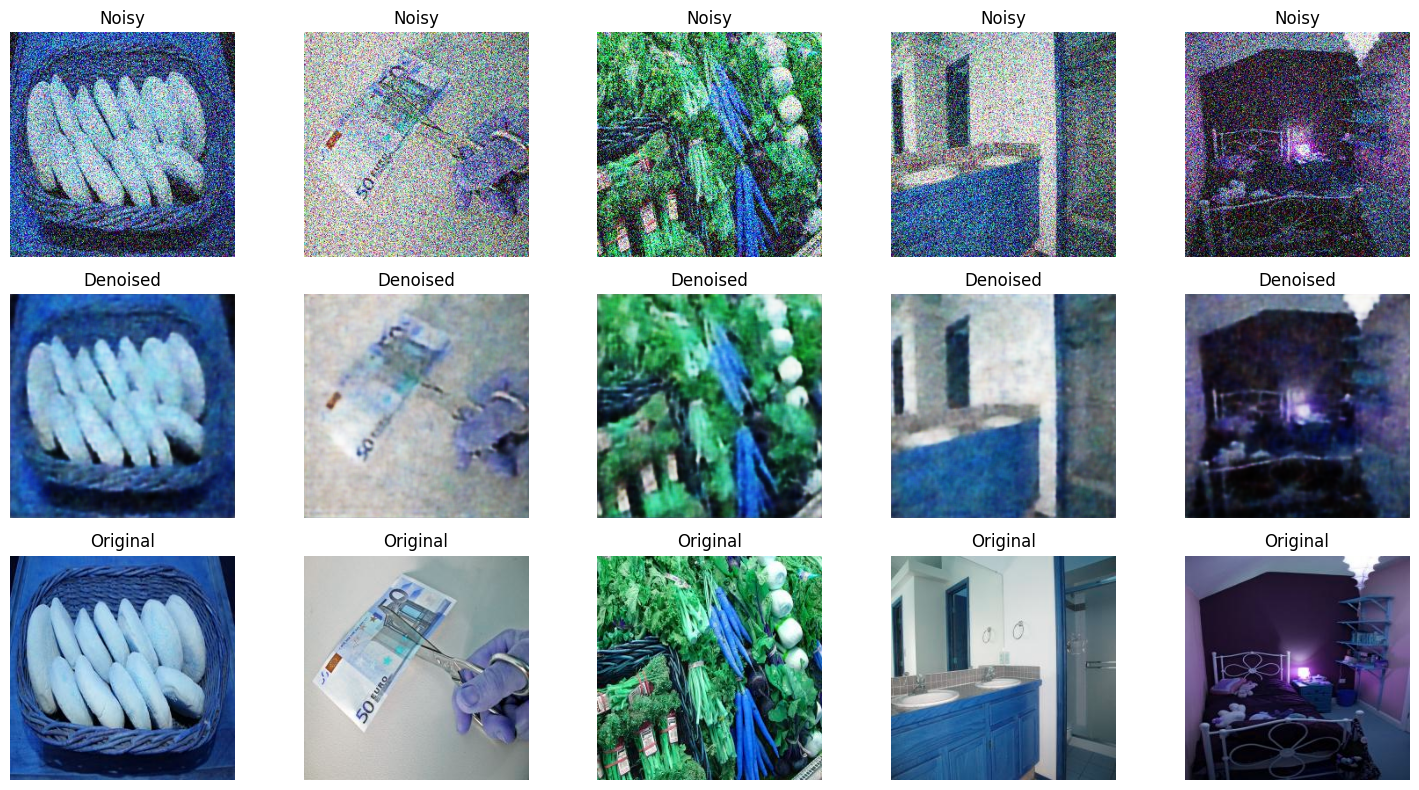

In [63]:
# %% [markdown]
# ## 8. Visualisation des Résultats
def plot_results(n=5):
    plt.figure(figsize=(15,8))
    predictions = model.predict(X_test[:n])
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(X_test[i])
        plt.title("Noisy")
        plt.axis('off')
        
        plt.subplot(3, n, i+1+n)
        plt.imshow(predictions[i])
        plt.title("Denoised")
        plt.axis('off')
        
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(y_test[i])
        plt.title("Original")
        plt.axis('off')
    
    # Add padding between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    plt.show()

plot_results()